# Final Project Analysis

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import dateutil.parser
import os
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import hashlib


## Data Preprocessing

In [30]:
file_path = os.path.join('..', 'data', 'QueryResults.csv')
_df = pd.read_csv(file_path)

In [31]:

_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  50000 non-null  int64 
 1   reputation          50000 non-null  int64 
 2   creationDate        50000 non-null  object
 3   lastAccessDate      50000 non-null  object
 4   views               50000 non-null  int64 
 5   upVotes             50000 non-null  int64 
 6   downVotes           50000 non-null  int64 
 7   postCount           50000 non-null  int64 
 8   commentCount        50000 non-null  int64 
 9   voteCount           50000 non-null  int64 
 10  editCount           50000 non-null  int64 
 11  suggestedEditCount  50000 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 4.6+ MB


In [32]:
_df['creationDate'] = pd.to_datetime(_df['creationDate'])
_df['lastAccessDate'] = pd.to_datetime(_df['lastAccessDate'])

In [33]:
fixed_date_string = "2024-11-29T18:51:13.002Z" 
fixed_date_object = dateutil.parser.isoparse(fixed_date_string)

df = _df.drop(columns=[
  'id', 
  # transform to "activeDays"
  'creationDate', 
  'lastAccessDate', 
  # transform to "votes"
  'upVotes', 
  'downVotes'
  ])


df['votes'] = _df['upVotes'] + _df['downVotes']
df['activeDays'] = (_df['lastAccessDate'] - _df['creationDate']).dt.days
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   reputation          50000 non-null  int64
 1   views               50000 non-null  int64
 2   postCount           50000 non-null  int64
 3   commentCount        50000 non-null  int64
 4   voteCount           50000 non-null  int64
 5   editCount           50000 non-null  int64
 6   suggestedEditCount  50000 non-null  int64
 7   votes               50000 non-null  int64
 8   activeDays          50000 non-null  int64
dtypes: int64(9)
memory usage: 3.4 MB


In [34]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled.head()

,reputation,views,postCount,commentCount,voteCount,editCount,suggestedEditCount,votes,activeDays
0,0.001874,0.001367,0.001802,0.003481,0.0,0.000934,0.01567,0.001732,0.529738
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.266973
2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.013769
3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000


## Model Fitting

### KMeans

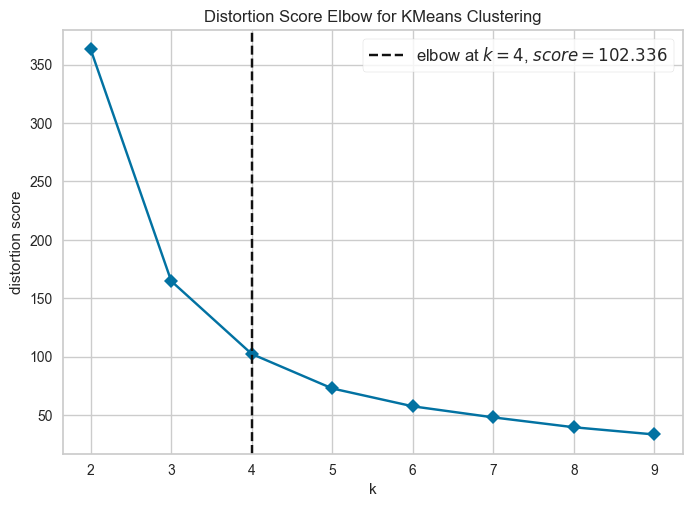

In [35]:
kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(2,10), timings=False)
visualizer.fit(df_scaled)
visualizer.show()
plt.show()

In [36]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(df_scaled)

KMeans(n_clusters=4, random_state=0)

### Agglomerative

In [37]:
# find linkage - find the linkage matrix for the given linkage method (uses cache if available)
def find_linkage(linkage_method):
  df_scaled_hash = hashlib.sha256(df_scaled.values.tobytes()).hexdigest()
  linkage_path = os.path.join('.', 'cache', f"linkage_{linkage_method}_{df_scaled_hash}.npy")

  if os.path.exists(linkage_path):
    print("Loading linkage matrix from cache")
    linkage_matrix = np.load(linkage_path, allow_pickle=True)
  else:
    print("Calculating linkage matrix from scratch")
    linkage_matrix = linkage(df_scaled, linkage_method)
    np.save(linkage_path, linkage_matrix)
  return linkage_matrix

agglomerative with linkage method: complete
Loading linkage matrix from cache


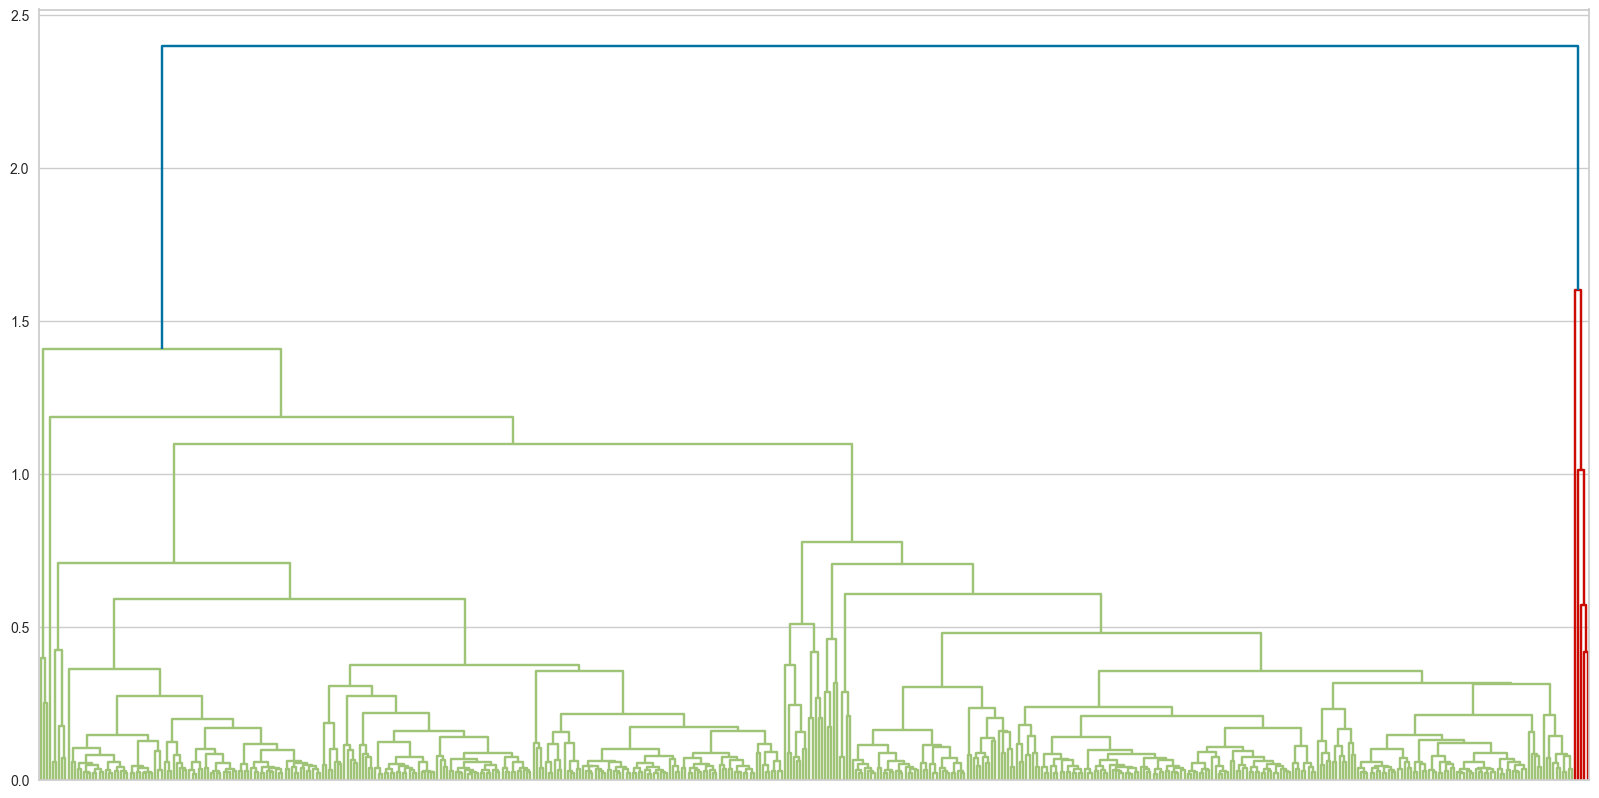

agglomerative with linkage method: single
Loading linkage matrix from cache


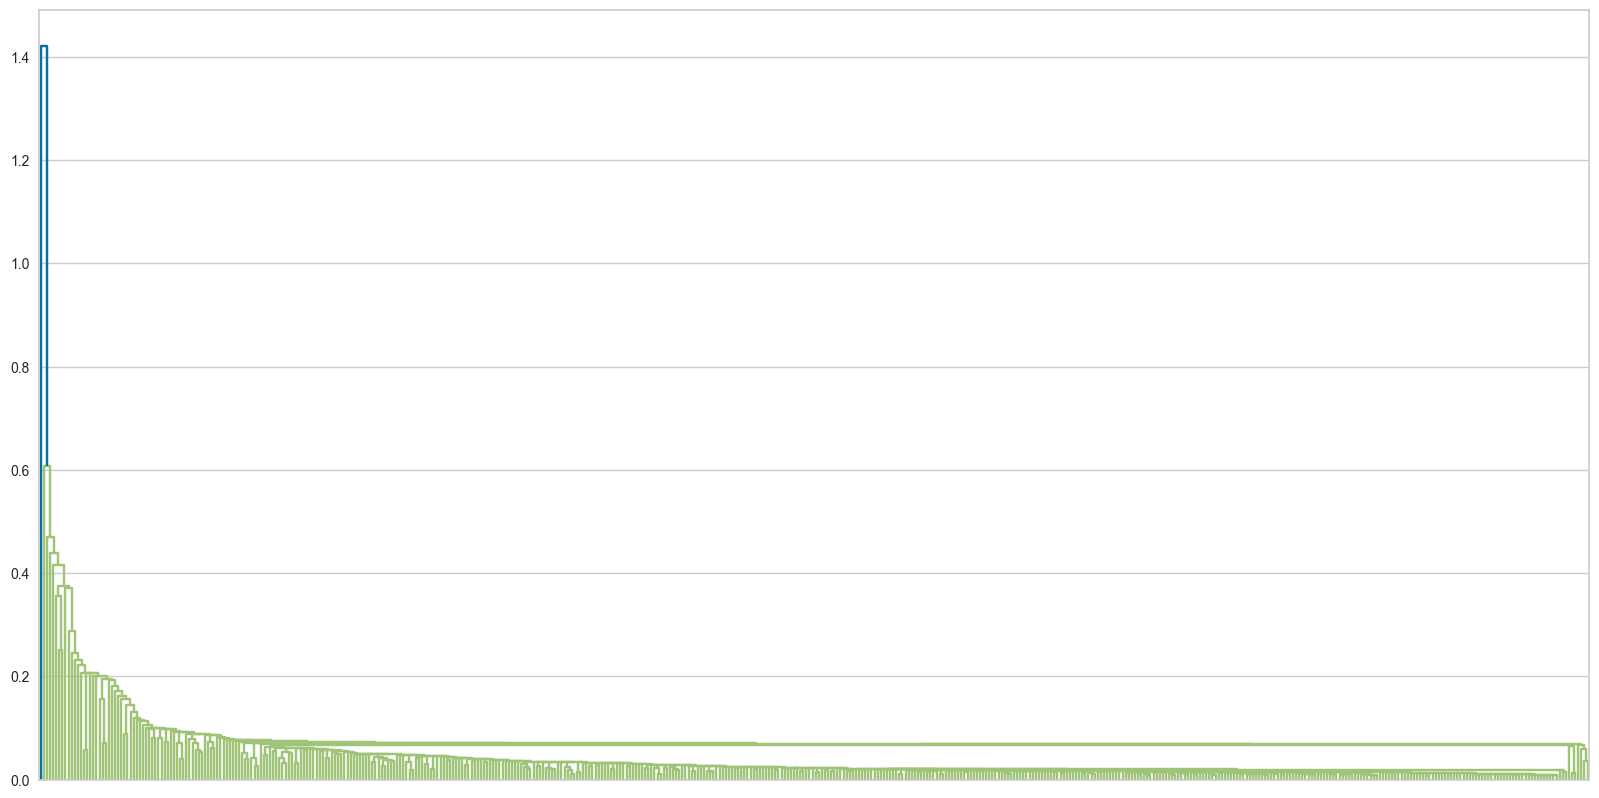

In [38]:
for linkage_method in ['complete', 'single']:
  print("agglomerative with linkage method:", linkage_method) 
  linkage_matrix = find_linkage(linkage_method)
  plt.figure(figsize=(20, 10))
  dendrogram(linkage_matrix, truncate_mode='lastp', p=500)
  plt.gca().get_xaxis().set_visible(False)
  plt.show()

In [39]:
# train with optimal number of clusters
# path = os.path.join('.', 'cache', 'models', 'agglomerative')
# agglomerative = AgglomerativeClustering(n_clusters=4, linkage=linkage_method, memory=path)
# agglomerative.fit(df_scaled)

## Analysis

In [45]:
def plot_clusters(labels):
  df_centroids = df_scaled.copy()
  df_centroids['cluster'] = labels
  df_centroids = df_centroids.groupby('cluster').mean()

  # FIRST PLOT - all the values together
  df_centroids_m = df_centroids.reset_index().melt(id_vars=["cluster"], var_name='features', value_name='values')

  sns.barplot(x='features', y='values', hue='cluster', data=df_centroids_m)
  plt.xticks(rotation=45)
  plt.show()

  # SECOND PLOT - each cluster separately
  for i in range(len(df_centroids)):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # SUB PLOT - plot with active days
    axes[0].bar(df_centroids.columns, df_centroids.iloc[i])
    axes[0].set_title(f"Cluster {i}")
    axes[0].set_ylabel('Scaled Values')
    axes[0].set_xlabel('Features')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_ylim(0, 1)


    # SUB PLOT - plot without active days
    df_centroids_no_active_days = df_centroids.drop(columns=['activeDays'])
    axes[1].bar(df_centroids_no_active_days.columns, df_centroids_no_active_days.iloc[i])
    axes[1].set_title(f"Cluster {i} (No Active Days)")
    axes[1].set_ylabel('Scaled Values')
    axes[1].set_xlabel('Features')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].set_ylim(0, .01)

    plt.tight_layout()
    plt.show()

  # add the number of items in cluster to each cluster
  df_centroids['COUNT'] = df_centroids.index.map(pd.Series(labels).value_counts())
  return df_centroids

### KMeans

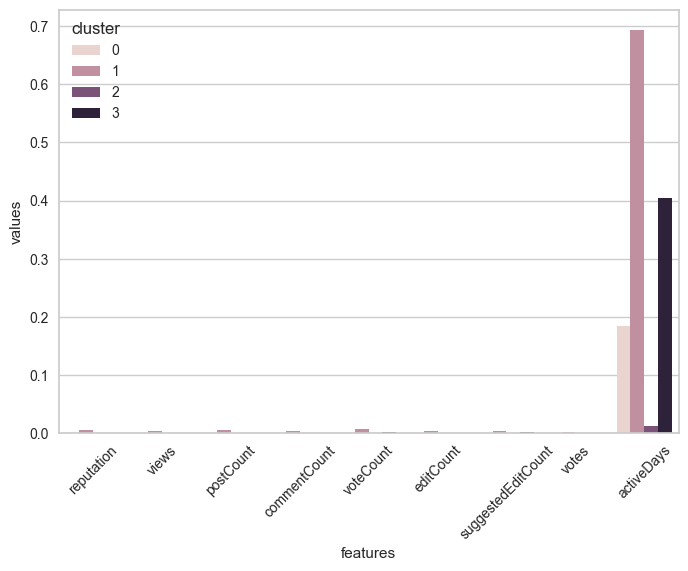

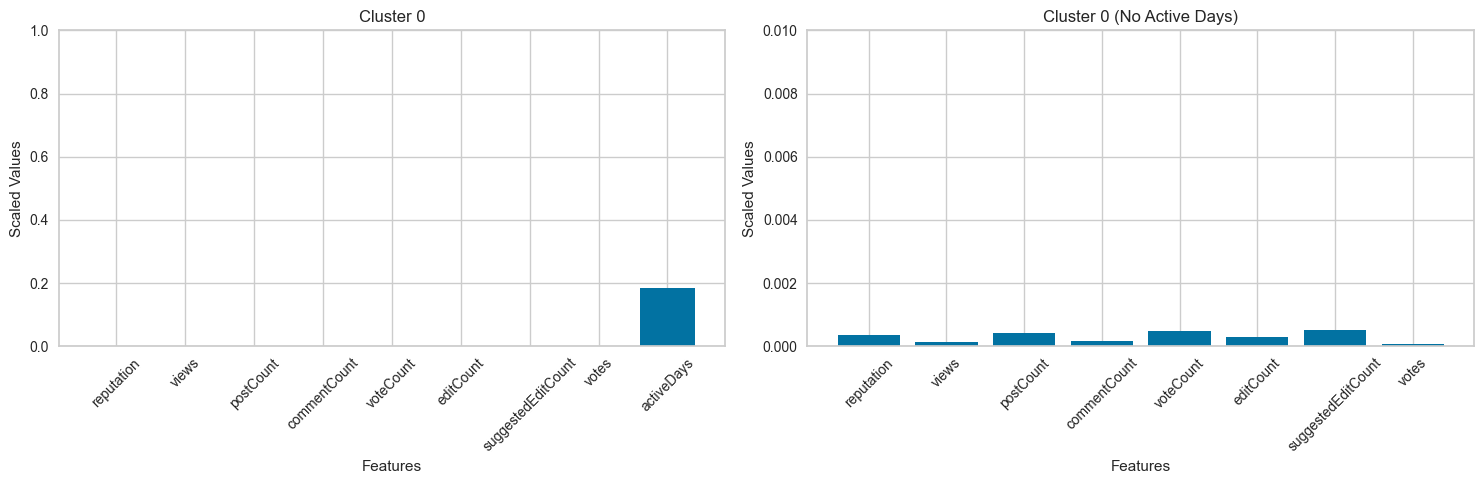

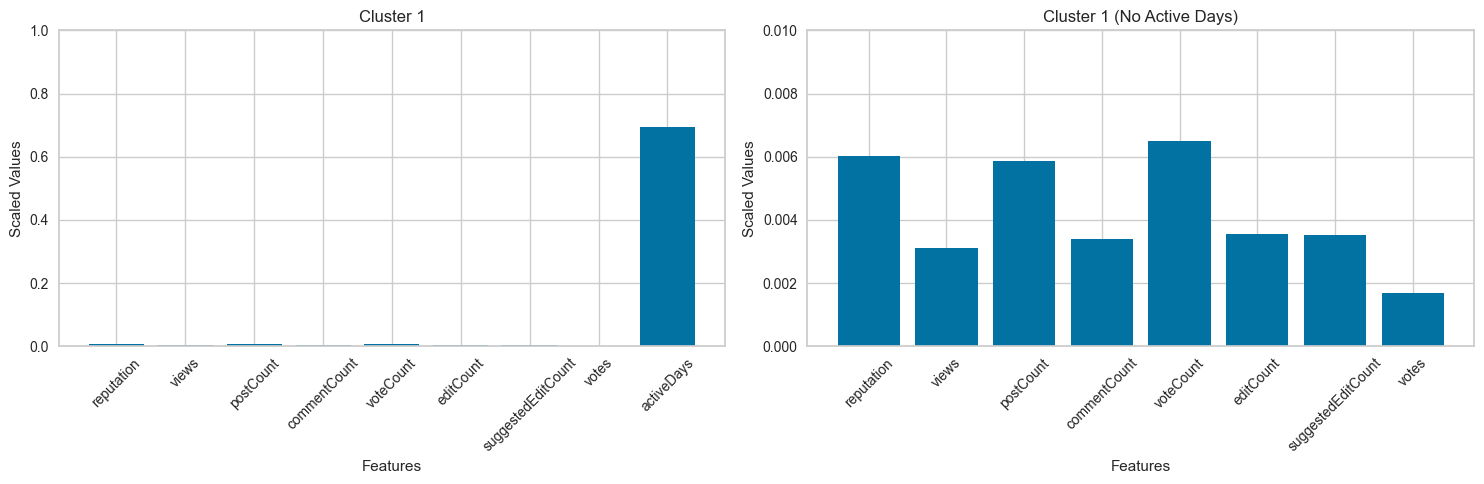

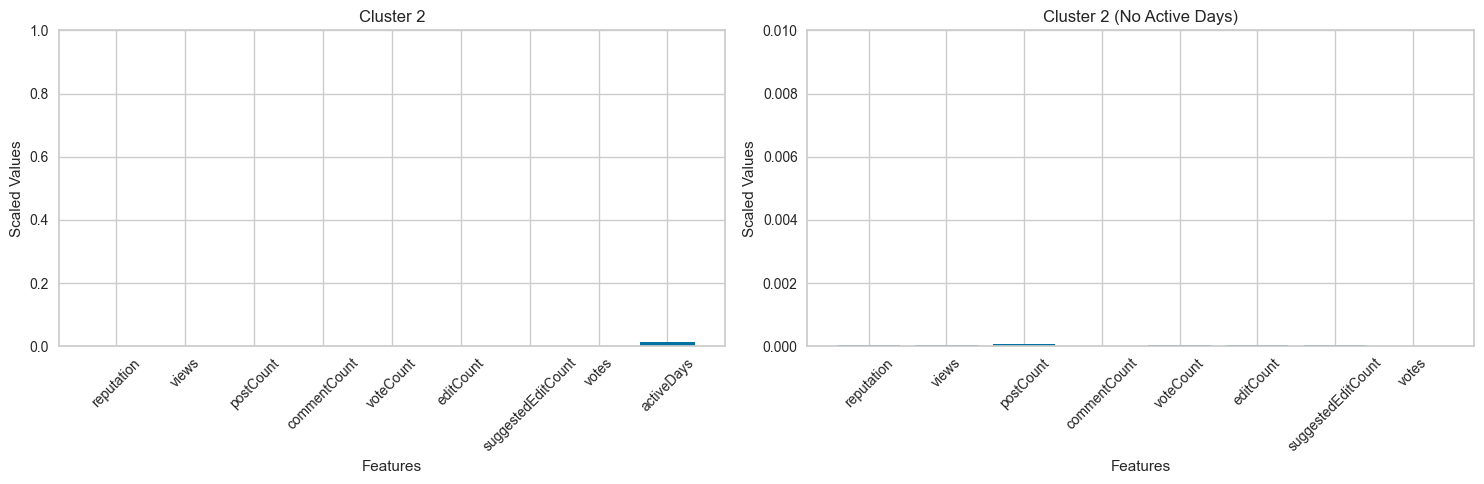

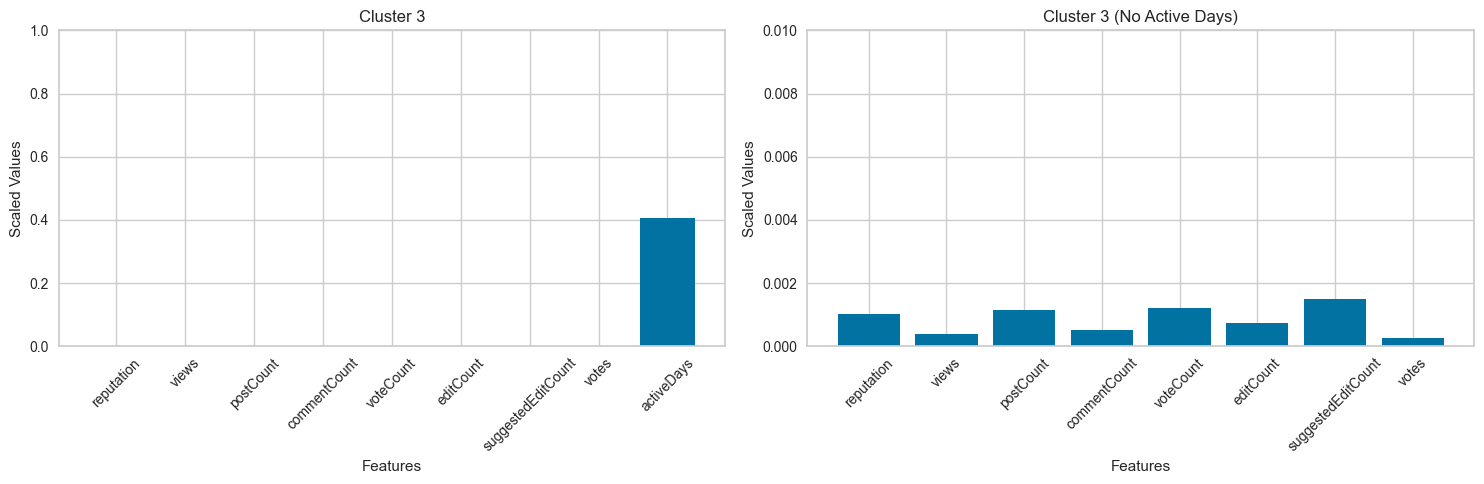

,reputation,views,postCount,commentCount,voteCount,editCount,suggestedEditCount,votes,activeDays,COUNT
cluster,,,,,,,,,,
0,0.000359,0.000146,0.000416,0.000165,0.000471,0.000287,0.000513,0.000065,0.183777,6208
1,0.006014,0.003104,0.005863,0.003390,0.006501,0.003553,0.003536,0.001682,0.693526,2079
2,0.000052,0.000025,0.000063,0.000020,0.000036,0.000044,0.000037,0.000004,0.011625,37996
3,0.001006,0.000378,0.001130,0.000515,0.001215,0.000734,0.001502,0.000244,0.404613,3717


In [47]:
plot_clusters(kmeans.labels_)

### Agglomerative

In [ ]:
# plot_clusters(agglomerative.labels_)
# skipped - we are going with KMeans